In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data Import

In [2]:
Sale_H1_2021,Employees,Customers,Product=pd.read_excel('Data_Sale_H1_2021.xlsx',sheet_name=None).values()

In [3]:
raw_data=Sale_H1_2021.merge(Customers,on='CustomerID').merge(Product,on='ProductID')
raw_data

,OrderID,EmployeeID,CustomerID,ProductID,OrderDate,OrderTime,ShippedDate,Status,UnitPrice,Pcs_per_Box,...,Level,CustmerName,latitude,longitude,Unnamed: 7,Unit(packed),Pcs per Unit,Brand,Core_SKU,Productname
0,IV00001,SV123456,WW001001,320201,14/1/2021,16:12,15/1/2021,Delivery confirmed,165300,3,...,Gold,Store001,21.1861,106.0763,NaN,Box,18,Brand C,No,C_ML0301010
1,IV00002,SV123456,WW001001,320201,21/1/2021,16:15,NaN,Cancel,84750,6,...,Gold,Store001,21.1861,106.0763,NaN,Box,18,Brand C,No,C_ML0301010
2,IV00335,SV123457,WW001001,320201,18/1/2021,16:35,19/1/2021,Delivery confirmed,84750,6,...,Gold,Store001,21.1861,106.0763,NaN,Box,18,Brand C,No,C_ML0301010
3,IV03241,SV123456,WW001001,320201,4/2/2021,16:16,5/2/2021,Delivery confirmed,84750,6,...,Gold,Store001,21.1861,106.0763,NaN,Box,18,Brand C,No,C_ML0301010
4,IV08529,SV123456,WW001001,320201,1/4/2021,16:24,1/4/2021,Delivery confirmed,169300,3,...,Gold,Store001,21.1861,106.0763,NaN,Box,18,Brand C,No,C_ML0301010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17387,IV06797,SV123459,WW001239,321377,31/3/2021,15:47,31/3/2021,Delivery confirmed,160500,6,...,Gold,Store353,21.1861,106.0763,NaN,Box,6,Brand B,Yes,B_MM3400010
17388,IV06798,SV123459,WW001239,321259,31/3/2021,15:47,31/3/2021,Delivery confirmed,342800,3,...,Gold,Store353,21.1861,106.0763,NaN,Box,3,Brand B,Yes,B_MM6400010
17389,IV02064,SV123459,WW001241,321239,18/1/2021,16:10,19/1/2021,Delivery confirmed,293000,3,...,Classic,Store372,10.9575,106.8426,NaN,Box,3,Brand B,No,B_MM6200010
17390,IV08901,SV123457,WW001341,321170,30/4/2021,17:50,NaN,Delivery confirmed,84000,6,...,Classic,Store059,9.7833,105.4708,NaN,Box,6,Brand C,No,C_LL0601010


In [4]:
raw_data.columns

Index(['OrderID', 'EmployeeID', 'CustomerID', 'ProductID', 'OrderDate',
       'OrderTime', 'ShippedDate', 'Status', 'UnitPrice', 'Pcs_per_Box',
       'Quantity (box)', 'Quantity (pcs)', 'Revenue before discount',
       'Discount', 'Extra Discount', 'Total Discount',
       'Revenue after discount', 'Region', 'City', 'Level', 'CustmerName',
       'latitude', 'longitude', 'Unnamed: 7', 'Unit(packed)', 'Pcs per Unit',
       'Brand', 'Core_SKU', 'Productname'],
      dtype='object')

In [5]:
features=['CustomerID',
        'Status', 'Revenue before discount',
        'Total Discount',
        'Region', 'Level',
        'Brand', 'Core_SKU']
Data_Revenue=raw_data[features].query('Status=="Delivery confirmed"').reset_index(drop=True).drop(columns=('Status'))

# Data Exploration

In [6]:
display(Data_Revenue.info(),
        Data_Revenue.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15624 entries, 0 to 15623
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               15624 non-null  object 
 1   Revenue before discount  15624 non-null  int64  
 2   Total Discount           15624 non-null  float64
 3   Region                   15624 non-null  object 
 4   Level                    15624 non-null  object 
 5   Brand                    15624 non-null  object 
 6   Core_SKU                 15624 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 854.6+ KB


None

,CustomerID,Revenue before discount,Total Discount,Region,Level,Brand,Core_SKU
0,WW001001,4463100,490941.0,South,Gold,Brand C,No
1,WW001001,508500,61020.0,South,Gold,Brand C,No
2,WW001001,508500,61020.0,South,Gold,Brand C,No
3,WW001001,1015800,126580.0,South,Gold,Brand C,No
4,WW001001,495900,87701.0,South,Gold,Brand C,No


#### Dữ liệu được thu thập từ tháng tháng 1 đến tháng 6/2021 với hơn 17414 giao dịch:
+ Công ty hiện phân phối 80 SKUs thuộc 4 Brand ( Brand A, Brand A Primier, Brand B, Brand C, BrandD)  trong đó có những Core_Sku  là những SKU cần phát triển trong tương lai.
+ Hệ thông khách gồm 374 Khách hàng phân theo 3 cấp bậc từ cao nhất là Signature, Gold ( được nhận thêm Extra Discount) riêng Classic chỉ được nhận 1 khoản Discount trong giao dịch
#### Công ty cần yêu cầu phân loại các nhóm khách hàng theo  các yếu tố để xây dựng chính sách bán hàng phù hợp cho từ tiệp khách hàng theo các theo tiêu chí:
+ Khác biệt về vị trí địa lý ( Region)
+ Khác biệt về doanh số bán hàng ( Revenue before discount)
+ Khác cấp bậc cửa hàng (Level)
+ Tất cả các Brand có phát triển đồng đều ở tất cả cửa hàng (Brand)
+ Các cửa hàng có tập trung phát triển sản phẩm chiến lược (Core_Sku )
+ Tỉ lệ Discount/Reveune có vượt quá ngân sách khuyến mãi 15%

In [7]:
Data_Revenue['Level_encoded'] = Data_Revenue['Level'].eq('Classic').astype(int) 
Data_Revenue # Level Signature có 5 quan sát nên ta gộp chung với nhóm Gold

,CustomerID,Revenue before discount,Total Discount,Region,Level,Brand,Core_SKU,Level_encoded
0,WW001001,4463100,490941.0,South,Gold,Brand C,No,0
1,WW001001,508500,61020.0,South,Gold,Brand C,No,0
2,WW001001,508500,61020.0,South,Gold,Brand C,No,0
3,WW001001,1015800,126580.0,South,Gold,Brand C,No,0
4,WW001001,495900,87701.0,South,Gold,Brand C,No,0
...,...,...,...,...,...,...,...,...
15619,WW001239,642000,96300.0,South,Gold,Brand B,Yes,0
15620,WW001239,685600,102840.0,South,Gold,Brand B,Yes,0
15621,WW001241,586000,128542.0,Central,Classic,Brand B,No,1
15622,WW001341,2016000,161280.0,South,Classic,Brand C,No,1


In [8]:
Data_Revenue['Core_SKU_encoded'] = Data_Revenue['Core_SKU'].eq('Yes').astype(int) 
Data_Revenue

,CustomerID,Revenue before discount,Total Discount,Region,Level,Brand,Core_SKU,Level_encoded,Core_SKU_encoded
0,WW001001,4463100,490941.0,South,Gold,Brand C,No,0,0
1,WW001001,508500,61020.0,South,Gold,Brand C,No,0,0
2,WW001001,508500,61020.0,South,Gold,Brand C,No,0,0
3,WW001001,1015800,126580.0,South,Gold,Brand C,No,0,0
4,WW001001,495900,87701.0,South,Gold,Brand C,No,0,0
...,...,...,...,...,...,...,...,...,...
15619,WW001239,642000,96300.0,South,Gold,Brand B,Yes,0,1
15620,WW001239,685600,102840.0,South,Gold,Brand B,Yes,0,1
15621,WW001241,586000,128542.0,Central,Classic,Brand B,No,1,0
15622,WW001341,2016000,161280.0,South,Classic,Brand C,No,1,0


In [9]:
dummies = pd.get_dummies(Data_Revenue[['Region','Brand']])
dummies

,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D
0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...
15619,0,0,1,0,0,1,0,0
15620,0,0,1,0,0,1,0,0
15621,1,0,0,0,0,1,0,0
15622,0,0,1,0,0,0,1,0


In [10]:
Data_Revenue=Data_Revenue.join(dummies).drop(columns=['Region','Brand','Level','Core_SKU'])
Data_Revenue

,CustomerID,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D
0,WW001001,4463100,490941.0,0,0,0,0,1,0,0,0,1,0
1,WW001001,508500,61020.0,0,0,0,0,1,0,0,0,1,0
2,WW001001,508500,61020.0,0,0,0,0,1,0,0,0,1,0
3,WW001001,1015800,126580.0,0,0,0,0,1,0,0,0,1,0
4,WW001001,495900,87701.0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15619,WW001239,642000,96300.0,0,1,0,0,1,0,0,1,0,0
15620,WW001239,685600,102840.0,0,1,0,0,1,0,0,1,0,0
15621,WW001241,586000,128542.0,1,0,1,0,0,0,0,1,0,0
15622,WW001341,2016000,161280.0,1,0,0,0,1,0,0,0,1,0


In [11]:
df_Data_Revenue=Data_Revenue.groupby('CustomerID').mean()
df_Data_Revenue

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D
CustomerID,,,,,,,,,,,,
WW001001,7.950251e+05,110012.448571,0.0,0.112782,0.0,0.0,1.0,0.240602,0.052632,0.624060,0.082707,0.0
WW001002,8.191760e+05,108064.972162,0.0,0.047297,0.0,1.0,0.0,0.168919,0.020270,0.459459,0.351351,0.0
WW001003,3.264179e+05,33188.228571,1.0,0.114286,0.0,0.0,1.0,0.657143,0.057143,0.000000,0.285714,0.0
WW001004,3.137885e+05,32927.068182,1.0,0.068182,0.0,0.0,1.0,0.681818,0.022727,0.000000,0.295455,0.0
WW001005,1.215205e+06,148212.605591,0.0,0.139785,0.0,0.0,1.0,0.559140,0.086022,0.193548,0.161290,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
WW001373,9.589500e+04,5721.750000,1.0,0.250000,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.0
WW001374,9.203175e+04,4447.750000,1.0,0.375000,1.0,0.0,0.0,0.625000,0.375000,0.000000,0.000000,0.0
WW001375,1.032030e+05,8564.000000,1.0,0.250000,0.0,1.0,0.0,0.750000,0.250000,0.000000,0.000000,0.0


# Data Segmentation

## Standardization

In [12]:
scaler=StandardScaler()
Data_Revenue_std=scaler.fit_transform(df_Data_Revenue)

# Hierarchical Clustering

In [13]:
hier_clust=linkage(Data_Revenue_std,method='ward')

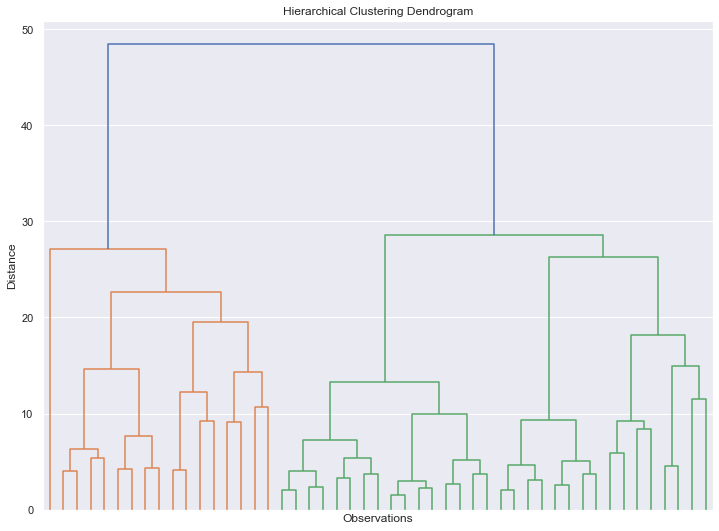

In [14]:
plt.figure(figsize=(12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

# K-means Clustering

In [15]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(Data_Revenue_std)
    wcss.append(kmeans.inertia_)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'K-means Clustering')

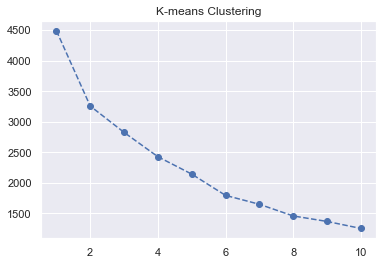

In [16]:
plt.figure(figsize=(6,4))
plt.plot(range(1,11),wcss,marker='o',linestyle='--')
plt.title('K-means Clustering')

In [17]:
kmeans=KMeans(n_clusters=4,init='k-means++',random_state=42)

In [18]:
kmeans.fit(Data_Revenue_std)

KMeans(n_clusters=4, random_state=42)

# Results

In [19]:
df_Data_Revenue_kmeans=df_Data_Revenue.copy()
df_Data_Revenue_kmeans['Segment K-means']=kmeans.labels_

In [20]:
df_segm_analysis=df_Data_Revenue_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D
Segment K-means,,,,,,,,,,,,
0,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000
1,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222
2,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000
3,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000


In [21]:
df_segm_analysis['N Obs']=df_Data_Revenue_kmeans[['Segment K-means','Revenue before discount']].groupby(['Segment K-means']).count()

In [22]:
df_segm_analysis['Prop Obs']=df_segm_analysis['N Obs']/df_segm_analysis['N Obs'].sum()

In [23]:
df_segm_analysis

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,,,,
0,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,67,0.179144
1,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,102,0.272727
2,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,98,0.262032
3,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,107,0.286096


In [24]:
df_segm_analysis['Discount_per_Revenue']=df_segm_analysis['Total Discount']/df_segm_analysis['Revenue before discount']

In [25]:
df_segm_analysis

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,N Obs,Prop Obs,Discount_per_Revenue
Segment K-means,,,,,,,,,,,,,,,
0,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,67,0.179144,0.112220
1,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,102,0.272727,0.130861
2,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,98,0.262032,0.114689
3,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,107,0.286096,0.109796


In [26]:
df_segm_analysis.rename({0:'Central_BrandA',
                         1:'Big_Revenue_BrandB',
                         2:'Sounth_BrandA',
                         3:'North_BrandA'})

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,N Obs,Prop Obs,Discount_per_Revenue
Segment K-means,,,,,,,,,,,,,,,
Central_BrandA,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,67,0.179144,0.112220
Big_Revenue_BrandB,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,102,0.272727,0.130861
Sounth_BrandA,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,98,0.262032,0.114689
North_BrandA,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,107,0.286096,0.109796


In [27]:
df_Data_Revenue_kmeans['Labels']=df_Data_Revenue_kmeans['Segment K-means'].map({0:'Central_BrandA',
                         1:'Big_Revenue_BrandB',
                         2:'Sounth_BrandA',
                         3:'North_BrandA'})                                 

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Segmentation Kmeans')

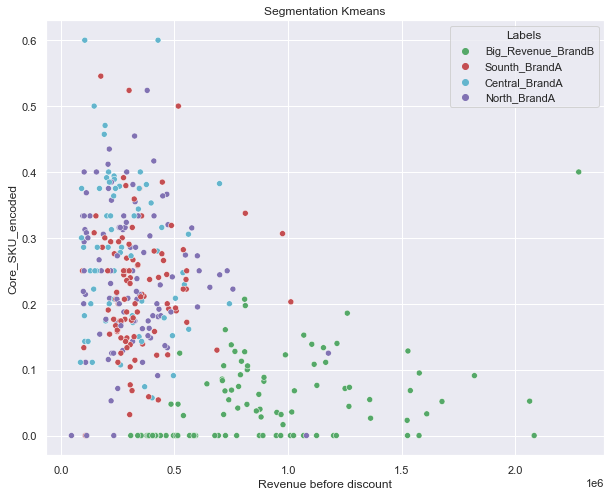

In [28]:
x_axis=df_Data_Revenue_kmeans['Revenue before discount']
y_axis=df_Data_Revenue_kmeans['Core_SKU_encoded']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_Data_Revenue_kmeans['Labels'],palette=['g','r','c','m'])
plt.title('Segmentation Kmeans')

In [29]:
# ngoài nhóm Big_Revenue có thể phân biệt, các nhóm còn lại trộn lẫn nên ta áp dụng PCA

# PCA

In [30]:
pca=PCA()

In [31]:
pca.fit(Data_Revenue_std)

PCA()

In [32]:
pca.explained_variance_ratio_

array([3.57212272e-01, 1.38765941e-01, 1.22003198e-01, 1.12528673e-01,
       8.42504356e-02, 7.82234414e-02, 5.75737992e-02, 3.47912395e-02,
       1.25466834e-02, 2.10431611e-03, 8.97562379e-33, 4.37776416e-33])

Text(0, 0.5, 'Cumulative Explained Variance')

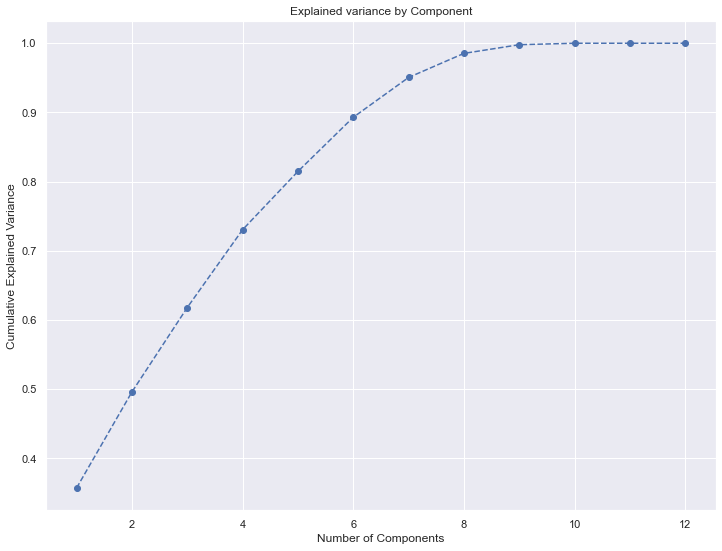

In [33]:
plt.figure(figsize=(12,9))
plt.plot(range(1,13),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [34]:
pca=PCA(n_components=5)

In [35]:
pca.fit(Data_Revenue_std)

PCA(n_components=5)

# PCA Results

In [36]:
pca.components_

array([[ 3.95285959e-01,  4.07970112e-01, -2.89836639e-01,
        -3.81209822e-01, -4.02890729e-02, -3.86416673e-04,
         3.65806738e-02, -3.81439787e-01, -3.51658053e-01,
         3.78812450e-01,  1.61162100e-01,  7.99368235e-02],
       [-3.59363490e-02, -1.62582138e-02, -6.23987301e-02,
         4.52255454e-02,  1.03897375e-02, -6.62091713e-01,
         6.65888071e-01,  4.04314769e-02,  2.33824955e-02,
         1.40938039e-01, -2.71318862e-01,  1.22335971e-01],
       [-1.38646590e-01, -1.48529011e-01,  3.29155212e-01,
        -1.41925074e-01,  6.39045496e-01, -3.91282168e-01,
        -1.74933382e-01, -2.56087594e-01, -9.07294566e-02,
         1.86239044e-02,  3.85096134e-01, -1.25256675e-01],
       [ 2.93398747e-01,  3.08729890e-01, -3.72494532e-01,
         3.20534884e-01,  5.17242065e-01, -1.35234167e-01,
        -3.26657711e-01,  1.45306396e-01,  2.58996227e-01,
        -1.31438478e-02, -3.02908647e-01,  6.67528651e-02],
       [-2.88054199e-01, -2.44835985e-01,  9.5695379

In [37]:
df_pca_comp=pd.DataFrame(data=pca.components_,
                        columns=df_Data_Revenue.columns.values,
                        index=['Component 1', 'Component 2','Component 3','Component 4','Component 5'])
df_pca_comp

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D
Component 1,0.395286,0.407970,-0.289837,-0.381210,-0.040289,-0.000386,0.036581,-0.381440,-0.351658,0.378812,0.161162,0.079937
Component 2,-0.035936,-0.016258,-0.062399,0.045226,0.010390,-0.662092,0.665888,0.040431,0.023382,0.140938,-0.271319,0.122336
Component 3,-0.138647,-0.148529,0.329155,-0.141925,0.639045,-0.391282,-0.174933,-0.256088,-0.090729,0.018624,0.385096,-0.125257
Component 4,0.293399,0.308730,-0.372495,0.320535,0.517242,-0.135234,-0.326658,0.145306,0.258996,-0.013144,-0.302909,0.066753
Component 5,-0.288054,-0.244836,0.095695,-0.218473,0.145269,0.116833,-0.249626,0.016248,-0.202115,0.371378,-0.472606,0.548392


([<matplotlib.axis.YTick at 0x2790af33970>,
 [Text(0, 0, 'Component 1'),
  Text(0, 1, 'Component 2'),
  Text(0, 2, 'Component 3'),
  Text(0, 3, 'Component 4'),
  Text(0, 4, 'Component 5')])

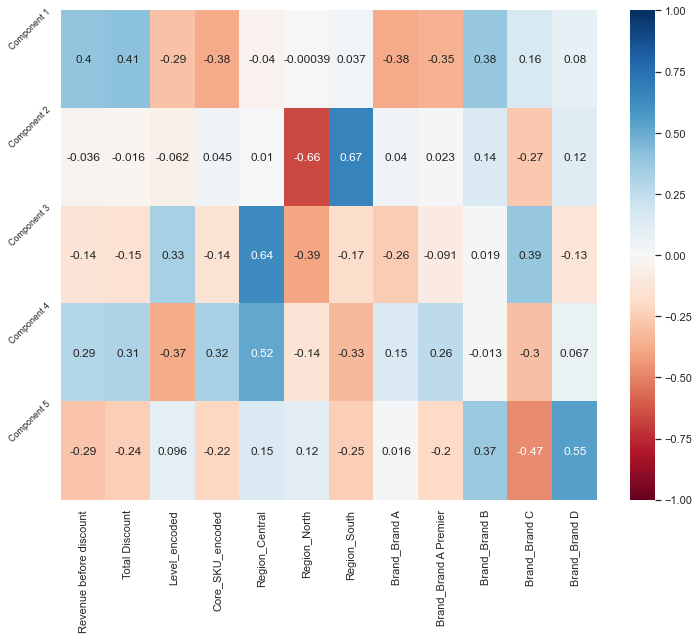

In [38]:
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
           vmin=-1,
           vmax=1,
           cmap='RdBu',
           annot=True)
plt.yticks([0,1,2,3,4],
          ['Component 1', 'Component 2','Component 3','Component 4','Component 5'],
          rotation=45,
          fontsize=9)

In [39]:
scores_pca=pca.transform(Data_Revenue_std)

# K -means clustering with PCA 

In [40]:
wcss=[]
for i in range(1,11):
    kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'K-means with PAC Clustering')

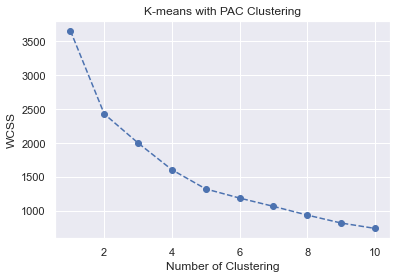

In [41]:
plt.figure(figsize=(6,4))
plt.plot(range(1,11),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clustering')
plt.ylabel('WCSS')
plt.title('K-means with PAC Clustering')

In [42]:
kmeans_pca=KMeans(n_clusters=4,init='k-means++',random_state=42)

In [43]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

# K -means clustering with PCA  Results

In [44]:
df_segm_pca_kmeans = pd.concat([df_Data_Revenue.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-5: ] = ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [45]:
df_segm_pca_kmeans

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,Component 1,Component 2,Component 3,Component 4,Component 5,Segment K-means PCA
0,7.950251e+05,110012.448571,0.0,0.112782,0.0,0.0,1.0,0.240602,0.052632,0.624060,0.082707,0.0,2.681741,1.680514,-0.922257,0.270485,-0.351104,2
1,8.191760e+05,108064.972162,0.0,0.047297,0.0,1.0,0.0,0.168919,0.020270,0.459459,0.351351,0.0,3.016965,-1.515078,-0.731848,0.028171,-0.205837,2
2,3.264179e+05,33188.228571,1.0,0.114286,0.0,0.0,1.0,0.657143,0.057143,0.000000,0.285714,0.0,-0.321415,1.115244,0.285720,-1.565216,-0.538159,0
3,3.137885e+05,32927.068182,1.0,0.068182,0.0,0.0,1.0,0.681818,0.022727,0.000000,0.295455,0.0,-0.092880,1.082726,0.373044,-1.790229,-0.393458,0
4,1.215205e+06,148212.605591,0.0,0.139785,0.0,0.0,1.0,0.559140,0.086022,0.193548,0.161290,0.0,2.398590,1.391210,-1.405723,1.066520,-1.663995,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,9.589500e+04,5721.750000,1.0,0.250000,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.0,-1.608530,1.581600,-0.421333,-1.192148,0.319065,0
370,9.203175e+04,4447.750000,1.0,0.375000,1.0,0.0,0.0,0.625000,0.375000,0.000000,0.000000,0.0,-3.140056,0.308632,1.230513,1.870603,0.132923,1
371,1.032030e+05,8564.000000,1.0,0.250000,0.0,1.0,0.0,0.750000,0.250000,0.000000,0.000000,0.0,-2.306929,-1.131275,-0.911501,-0.175480,0.496864,3
372,4.045500e+05,56455.000000,1.0,0.000000,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.0,2.312249,1.772414,0.453065,-1.745509,1.386702,2


In [46]:
df_segm_pca_kmeans_freq=df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,Component 1,Component 2,Component 3,Component 4,Component 5
Segment K-means PCA,,,,,,,,,,,,,,,,,
0,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,-0.786805,1.441121,-0.268173,-0.734161,-0.453098
1,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,-1.493218,0.101856,1.468140,1.322997,0.271930
2,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,2.941381,-0.058280,0.090767,0.121712,0.069641
3,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,-1.148303,-1.328128,-0.760212,-0.272034,0.178326


In [47]:
df_segm_pca_kmeans_freq['N Obs']=df_segm_pca_kmeans[['Segment K-means PCA','Core_SKU_encoded']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,Component 1,Component 2,Component 3,Component 4,Component 5,N Obs
Segment K-means PCA,,,,,,,,,,,,,,,,,,
0,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,-0.786805,1.441121,-0.268173,-0.734161,-0.453098,98
1,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,-1.493218,0.101856,1.468140,1.322997,0.271930,67
2,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,2.941381,-0.058280,0.090767,0.121712,0.069641,102
3,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,-1.148303,-1.328128,-0.760212,-0.272034,0.178326,107


In [59]:
df_segm_pca_kmeans_freq['Prop Obs']=df_segm_pca_kmeans_freq['N Obs']/df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq['Discount_per_Revenue']=df_segm_pca_kmeans_freq['Total Discount']/df_segm_pca_kmeans_freq['Revenue before discount']
df_segm_pca_kmeans_freq

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,Component 1,Component 2,Component 3,Component 4,Component 5,N Obs,Prop Obs,Discount_per_Revenue
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,
South_BrandA,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,-0.786805,1.441121,-0.268173,-0.734161,-0.453098,98,0.262032,0.114689
Central_BrandA,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,-1.493218,0.101856,1.468140,1.322997,0.271930,67,0.179144,0.112220
Big_Revenue_BrandB,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,2.941381,-0.058280,0.090767,0.121712,0.069641,102,0.272727,0.130861
North_BrandA,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,-1.148303,-1.328128,-0.760212,-0.272034,0.178326,107,0.286096,0.109796


In [49]:
df_segm_pca_kmeans_freq=df_segm_pca_kmeans_freq.rename({0:'South_BrandA',
                         1:'Central_BrandA',
                         2:'Big_Revenue_BrandB',
                         3:'North_BrandA'} )
df_segm_pca_kmeans_freq

,Revenue before discount,Total Discount,Level_encoded,Core_SKU_encoded,Region_Central,Region_North,Region_South,Brand_Brand A,Brand_Brand A Premier,Brand_Brand B,Brand_Brand C,Brand_Brand D,Component 1,Component 2,Component 3,Component 4,Component 5,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,,,,,,,
South_BrandA,346672.833670,39759.693554,0.938776,0.223772,0.000000,0.000000,1.000000,0.635079,0.136244,0.113594,0.115083,0.000000,-0.786805,1.441121,-0.268173,-0.734161,-0.453098,98,0.262032
Central_BrandA,287026.440135,32210.082038,0.925373,0.278422,1.000000,0.000000,0.000000,0.679360,0.166965,0.048153,0.105521,0.000000,-1.493218,0.101856,1.468140,1.322997,0.271930,67,0.179144
Big_Revenue_BrandB,889313.663912,116376.241717,0.450980,0.051597,0.245098,0.401961,0.352941,0.138644,0.026804,0.596626,0.237704,0.000222,2.941381,-0.058280,0.090767,0.121712,0.069641,102,0.272727
North_BrandA,324055.395941,35580.139603,0.915888,0.236674,0.000000,1.000000,0.000000,0.692576,0.147999,0.034260,0.125164,0.000000,-1.148303,-1.328128,-0.760212,-0.272034,0.178326,107,0.286096


In [50]:
df_segm_pca_kmeans['Legend']=df_segm_pca_kmeans['Segment K-means PCA'].map({0:'South_BrandA',
                         1:'Central_BrandA',
                         2:'Big_Revenue_BrandB',
                         3:'North_BrandA'})

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


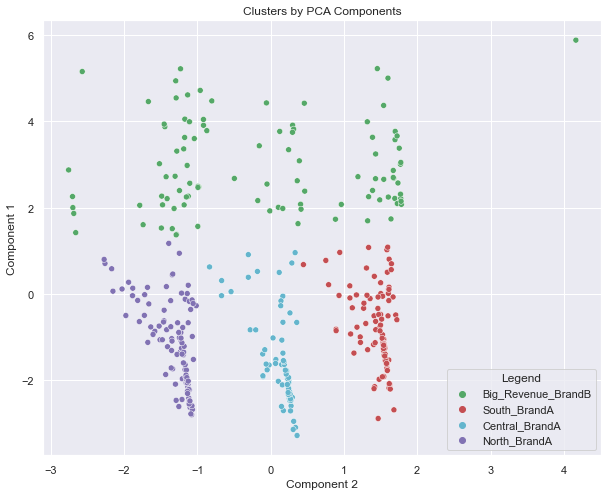

In [51]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

### Summerise:
Các nhóm [North_BrandA, Central_Brand_A, South_Brand_A]:
+ Các nhóm không có khác biệt quá lớn về doanh số (287026.440135-346672.833670)
+ Các nhóm chủ yếu phân phối Brand A (0.635079-0.692576)
+ Cần phát triển Brand_B tại nhóm [North_BrandA, Central_BrandA] (0.048153-0.048153	) so với nhóm [South_BrandA] (0.113594)
+ Tất cả các nhóm đều không phân phối Brand_D và sự khác biệt về Brand_C không đáng kể
+ Nhóm phân phối tốt nhóm core_Sku(0.236674-0.278422)
+ Các cửa hàng nhóm Classic chủ yếu thuộc nhóm này (0.915888-0.938776)
+ tỉ lệ Discount/Revenue ở mức cho phép <15% (0.109796-0.114689)


Nhóm [Big_Revenue_BrandB]:
+ Có doanh só vượt trội gấp 3 lần so với các nhóm còn lại.(889313.663912)
+ Chủ yếu phân phối Brand_B (0.596626)
+ Có phân phối Brand_D nhưng không đáng kể (0.000222)
+ Cần tập trung phát triển Core_Sku tại nhóm này
+ Các cửa hàng Level Signature và Gold chủ yếu thuộc nhóm này và thuộc tất các các Region
+ tỉ lệ Discount/Revenue ở mức cho phép <15%  và cao hơn 3 nhóm còn lại(0.130861)